In [22]:
# Cell 1: TẢI DỮ LIỆU ĐÃ XỬ LÝ và Tách Tập Dữ liệu

# Import các thư viện cần thiết
# Import các thư viện cần thiết
import pandas as pd
from sklearn.model_selection import train_test_split
# DÒNG NÀY PHẢI BAO GỒM TẤT CẢ CÁC CHỈ SỐ:
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score 
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC # Cần có nếu bạn dùng SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings

warnings.filterwarnings('ignore')

# --- 1. TẢI DỮ LIỆU ĐÃ XỬ LÝ ---
try:
    # Tải các file đã được lưu vào thư mục ./input/process/
    X_train_processed = pd.read_csv('../input/process/X_train_processed.csv')
    X_test_processed = pd.read_csv('../input/process/X_test_processed.csv')
    y_df = pd.read_csv('../input/process/y_train.csv')
    y = y_df['Class'] # Lấy biến mục tiêu
    
    # Tải Id (cần cho file submission cuối cùng)
    df_test_original = pd.read_csv('../input/test.csv')
    test_id = df_test_original['Id']
    
    print("Tải dữ liệu đã xử lý thành công!")
    
except FileNotFoundError:
    print("LỖI: Không tìm thấy các file dữ liệu đã xử lý. Vui lòng chạy lại file preprocessing.ipynb để tạo các file CSV cần thiết.")
    exit()


# --- 2. TÁCH TẬP TRAIN/VALIDATION ---
# Tách 80% Train, 20% Validation để đánh giá
X_train, X_val, y_train, y_val = train_test_split(
    X_train_processed, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y 
)

print(f"Kích thước tập huấn luyện: {X_train.shape}")
print(f"Kích thước tập xác thực: {X_val.shape}")

Tải dữ liệu đã xử lý thành công!
Kích thước tập huấn luyện: (11516, 28)
Kích thước tập xác thực: (2880, 28)


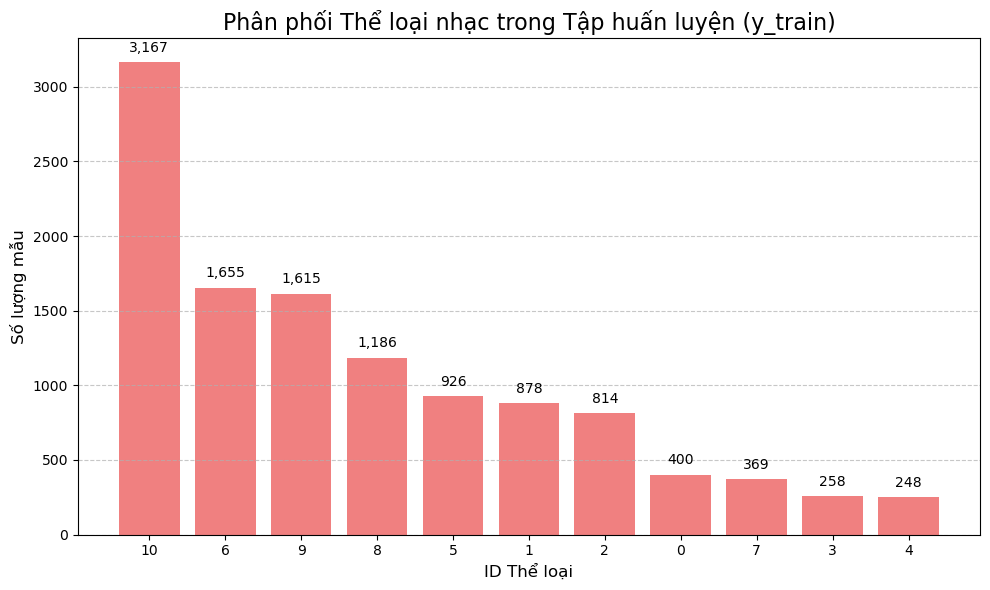

In [23]:
import matplotlib.pyplot as plt
# (Sử dụng df_y_train nếu bạn có trong Cell 1, nếu không thì dùng y_train/y_val đã tách)
# Giả định: y_train là Series/DataFrame chứa nhãn lớp đã được tách ra từ Cell 1. 

# Tính toán phân phối lớp (Sử dụng y_train)
# Lưu ý: Cột nhãn trong file của bạn là 'Class'.
genre_counts = y_train.value_counts().reset_index() 
genre_counts.columns = ['Genre_ID', 'Count']

# Sắp xếp và vẽ biểu đồ
genre_counts = genre_counts.sort_values(by='Count', ascending=False)

plt.figure(figsize=(10, 6))
bars = plt.bar(genre_counts['Genre_ID'].astype(str), genre_counts['Count'], color='lightcoral')

plt.title('Phân phối Thể loại nhạc trong Tập huấn luyện (y_train)', fontsize=16)
plt.xlabel('ID Thể loại', fontsize=12)
plt.ylabel('Số lượng mẫu', fontsize=12)

# Thêm giá trị số lượng lên trên mỗi cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, 
             f'{yval:,.0f}', ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('../doc/fig/genre_distribution.png') 
plt.show()

In [24]:
# Cell 2: Baseline Model (Logistic Regression)

# LogReg là Baseline, sử dụng class_weight để chống mất cân bằng lớp
logreg = LogisticRegression(
    multi_class='multinomial', 
    solver='lbfgs', 
    C=1.0, 
    max_iter=1000, 
    random_state=42,
    class_weight='balanced' 
)

print("Bắt đầu huấn luyện Logistic Regression...")
logreg.fit(X_train, y_train)

y_pred_logreg = logreg.predict(X_val)
f1_macro = f1_score(y_val, y_pred_logreg, average='macro')

print(f"\n--- Đánh giá Logistic Regression (Baseline) ---")
print(f"Macro F1 Score: {f1_macro:.4f}")
print("Classification Report:")
print(classification_report(y_val, y_pred_logreg))

Bắt đầu huấn luyện Logistic Regression...

--- Đánh giá Logistic Regression (Baseline) ---
Macro F1 Score: 0.3639
Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.41      0.24       100
           1       0.09      0.04      0.06       220
           2       0.24      0.29      0.27       204
           3       0.29      0.75      0.42        64
           4       0.12      0.68      0.20        62
           5       0.61      0.76      0.68       231
           6       0.39      0.16      0.22       414
           7       0.66      0.89      0.76        92
           8       0.42      0.74      0.53       297
           9       0.38      0.29      0.33       404
          10       0.49      0.22      0.31       792

    accuracy                           0.36      2880
   macro avg       0.35      0.48      0.36      2880
weighted avg       0.40      0.36      0.34      2880



In [25]:
# Cell 3: Huấn luyện và So sánh 5 Mô hình (CẬP NHẬT CÁC CHỈ SỐ ĐÁNH GIÁ)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.svm import SVC 
# Đã thêm các thư viện cần thiết vào Cell 1: accuracy_score, precision_score, recall_score

# Định nghĩa 5 mô hình đa dạng (tham số không đổi)
models = {
    'RandomForest': RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=300, max_depth=10, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=42, objective='multi:softmax', eval_metric='mlogloss', n_estimators=300, max_depth=7, learning_rate=0.1, use_label_encoder=False, n_jobs=-1),
    'SVC': SVC(random_state=42, kernel='linear', C=1.0, class_weight='balanced'), 
    'HistGBoost': HistGradientBoostingClassifier(random_state=42, max_iter=300, max_depth=10, learning_rate=0.1, verbose=0), 
    'KNeighbors': KNeighborsClassifier(n_neighbors=15, weights='distance', n_jobs=-1) 
}

results = {}

print("Bắt đầu huấn luyện và đánh giá 5 mô hình...")

for name, model in models.items():
    print(f"\n====================================")
    print(f"--- Huấn luyện: {name} ---")
    
    # IN ĐẦY ĐỦ THÔNG SỐ TRƯỚC KHI HUẤN LUYỆN
    print("Thông số mô hình:")
    params_to_print = {k: v for k, v in model.get_params().items() if v is not None and k in ['n_estimators', 'max_depth', 'learning_rate', 'n_neighbors', 'class_weight', 'kernel', 'C']}
    print(params_to_print)
    
    # Huấn luyện mô hình
    model.fit(X_train, y_train)
    
    # Dự đoán và Đánh giá
    y_pred = model.predict(X_val)
    
    # TÍNH TOÁN CÁC CHỈ SỐ MỚI
    f1_macro = f1_score(y_val, y_pred, average='macro')
    accuracy = accuracy_score(y_val, y_pred)
    precision_macro = precision_score(y_val, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_val, y_pred, average='macro', zero_division=0)
    
    results[name] = {
        'model': model,
        'f1_macro': f1_macro,
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro
    }
    
    print(f"\n{name} Macro F1 Score: {f1_macro:.4f}")
    print(f"Classification Report cho {name}:")
    print(classification_report(y_val, y_pred, zero_division=0)) # In chi tiết cho từng lớp

# Hiển thị kết quả tổng hợp
print("\n====================================")
print("KẾT QUẢ TỔNG HỢP (So sánh các Metrics quan trọng)")
print("====================================")

# Tạo DataFrame so sánh
comparison_df = pd.DataFrame({
    name: {
        'F1 Macro': res['f1_macro'],
        'Accuracy': res['accuracy'],
        'Precision Macro': res['precision_macro'],
        'Recall Macro': res['recall_macro']
    } for name, res in results.items()
}).T

# Sắp xếp theo F1 Macro
comparison_df = comparison_df.sort_values(by='F1 Macro', ascending=False)
display(comparison_df.style.format("{:.4f}"))

best_f1 = comparison_df.iloc[0]['F1 Macro']
best_model_name = comparison_df.index[0]
final_best_model = results[best_model_name]['model']

# Cập nhật biến best_f1 để dùng trong Cell 4
best_f1_submission = best_f1
print(f"====================================")
print(f"🥇 Mô hình tốt nhất là: {best_model_name} với F1 Macro: {best_f1:.4f}")

Bắt đầu huấn luyện và đánh giá 5 mô hình...

--- Huấn luyện: RandomForest ---
Thông số mô hình:
{'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 300}

RandomForest Macro F1 Score: 0.4039
Classification Report cho RandomForest:
              precision    recall  f1-score   support

           0       0.18      0.49      0.26       100
           1       0.06      0.02      0.03       220
           2       0.30      0.44      0.35       204
           3       0.38      0.64      0.48        64
           4       0.15      0.71      0.25        62
           5       0.66      0.76      0.71       231
           6       0.39      0.22      0.28       414
           7       0.68      0.92      0.78        92
           8       0.45      0.74      0.56       297
           9       0.47      0.35      0.40       404
          10       0.51      0.25      0.33       792

    accuracy                           0.40      2880
   macro avg       0.38      0.51      0.40      2880
we

,F1 Macro,Accuracy,Precision Macro,Recall Macro
HistGBoost,0.4360,0.4743,0.4578,0.4296
XGBoost,0.4305,0.4503,0.4608,0.4162
RandomForest,0.4039,0.3969,0.3837,0.5054
SVC,0.3775,0.3698,0.3654,0.4819
KNeighbors,0.3728,0.4045,0.3959,0.3683


🥇 Mô hình tốt nhất là: HistGBoost với F1 Macro: 0.4360


In [27]:
# Cell 4: Tạo Tệp Gửi (Submission) cho TẤT CẢ CÁC MÔ HÌNH ĐƠN LẺ

from pathlib import Path

# --- 1. ĐỊNH NGHĨA THƯ MỤC LƯU TRỮ ---
# Đường dẫn tương đối từ vị trí hiện tại của Notebook (giả sử là /code/)
OUTPUT_DIR = Path('../output/single_model/') 

# Tạo thư mục nếu nó chưa tồn tại
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print(f"Đã đảm bảo thư mục đầu ra tồn tại: {OUTPUT_DIR.resolve()}")

# LƯU Ý: Biến 'results' chứa tất cả các mô hình đã được huấn luyện và điểm F1 Macro từ Cell 3.
global_results = results 

print("\n--- BẮT ĐẦU TẠO TỆP SUBMISSION CHO TẤT CẢ CÁC MÔ HÌNH ĐƠN LẺ ---")

for name, res in global_results.items():
    model = res['model']
    # Lấy điểm F1 Macro từ bước đánh giá trên tập Validation
    f1_score_val = res['f1_macro'] 
    
    print(f"\n[Huấn luyện lại và Tạo Submission cho {name}]")
    
    # 1. Huấn luyện lại mô hình trên toàn bộ tập huấn luyện đã xử lý
    model.fit(X_train_processed, y)
    
    # 2. Dự đoán trên tập Test
    y_test_pred = model.predict(X_test_processed)
    
    # 3. Tạo DataFrame Submission
    submission_df = pd.DataFrame({
        'Id': test_id, # Đã được tải ở Cell 1
        'Class': y_test_pred.astype(int) 
    })
    
    # 4. Lưu tệp Submission
    # Định dạng tên file: submission_[ModelName]_F1_[F1Score].csv
    submission_filename = f'submission_{name}_F1_{f1_score_val:.4f}.csv'
    
    # Lưu file vào thư mục OUTPUT_DIR
    submission_df.to_csv(OUTPUT_DIR / submission_filename, index=False)
    
    print(f"-> Đã tạo tệp: {submission_filename} (F1 Macro Validation: {f1_score_val:.4f})")

print("\n--- QUÁ TRÌNH TẠO TẤT CẢ CÁC TỆP SUBMISSION ĐƠN LẺ ĐÃ HOÀN TẤT ---")

Đã đảm bảo thư mục đầu ra tồn tại: D:\MachineLearning2025\Kaggle_Challenge\challenge3_MusicGenreClassification_\output\single_model

--- BẮT ĐẦU TẠO TỆP SUBMISSION CHO TẤT CẢ CÁC MÔ HÌNH ĐƠN LẺ ---

[Huấn luyện lại và Tạo Submission cho RandomForest]
-> Đã tạo tệp: submission_RandomForest_F1_0.4039.csv (F1 Macro Validation: 0.4039)

[Huấn luyện lại và Tạo Submission cho XGBoost]
-> Đã tạo tệp: submission_XGBoost_F1_0.4305.csv (F1 Macro Validation: 0.4305)

[Huấn luyện lại và Tạo Submission cho SVC]
-> Đã tạo tệp: submission_SVC_F1_0.3775.csv (F1 Macro Validation: 0.3775)

[Huấn luyện lại và Tạo Submission cho HistGBoost]
-> Đã tạo tệp: submission_HistGBoost_F1_0.4360.csv (F1 Macro Validation: 0.4360)

[Huấn luyện lại và Tạo Submission cho KNeighbors]
-> Đã tạo tệp: submission_KNeighbors_F1_0.3728.csv (F1 Macro Validation: 0.3728)

--- QUÁ TRÌNH TẠO TẤT CẢ CÁC TỆP SUBMISSION ĐƠN LẺ ĐÃ HOÀN TẤT ---


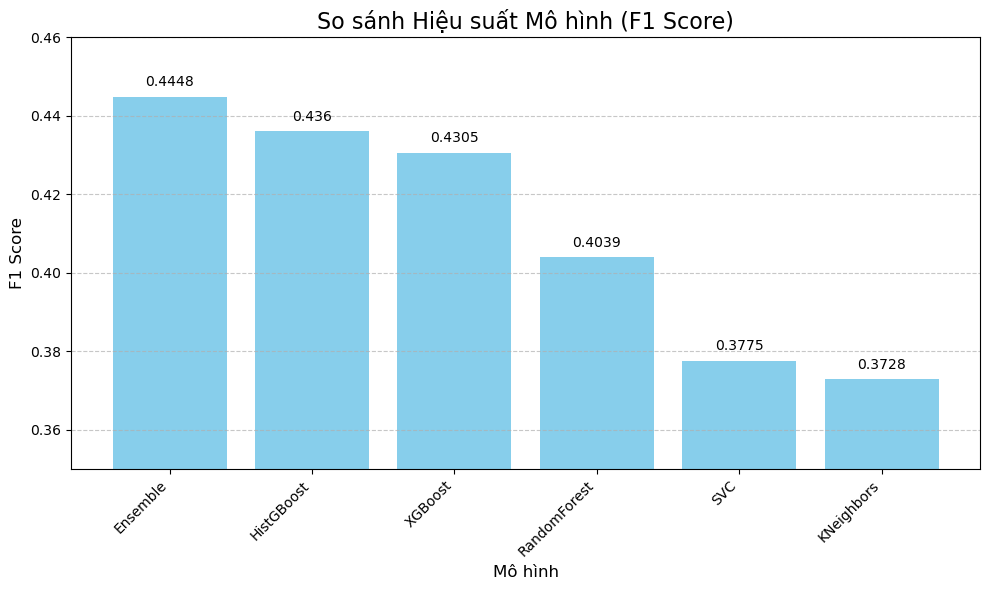

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Dữ liệu F1 Score tổng hợp từ các submission (bao gồm cả Ensemble)
data = {
    'Model': [
        'KNeighbors', 'SVC', 'RandomForest', 'XGBoost', 'HistGBoost', 'Ensemble'
    ],
    'F1 Score': [
        0.3728, 0.3775, 0.4039, 0.4305, 0.4360, 0.4448
    ]
}
df_f1 = pd.DataFrame(data)

# Sắp xếp dữ liệu theo F1 Score giảm dần
df_f1 = df_f1.sort_values(by='F1 Score', ascending=False).reset_index(drop=True)

# Tạo biểu đồ
plt.figure(figsize=(10, 6))
bars = plt.bar(df_f1['Model'], df_f1['F1 Score'], color='skyblue')

# Đặt tiêu đề và nhãn
plt.title('So sánh Hiệu suất Mô hình (F1 Score)', fontsize=16)
plt.xlabel('Mô hình', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.ylim(0.35, 0.46) # Giới hạn trục y để làm nổi bật sự khác biệt

# Thêm giá trị F1 Score lên trên mỗi cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.002, 
             round(yval, 4), ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../doc/fig/model_f1_comparison.png') 
plt.show()

Bắt đầu tính toán và vẽ đường cong ROC Micro-average cho 5 mô hình...
-> Đang huấn luyện và tính AUC cho: KNeighbors...
-> Đang huấn luyện và tính AUC cho: SVC...
-> Đang huấn luyện và tính AUC cho: RandomForest...
-> Đang huấn luyện và tính AUC cho: XGBoost...
-> Đang huấn luyện và tính AUC cho: HistGBoost...
Hoàn tất.


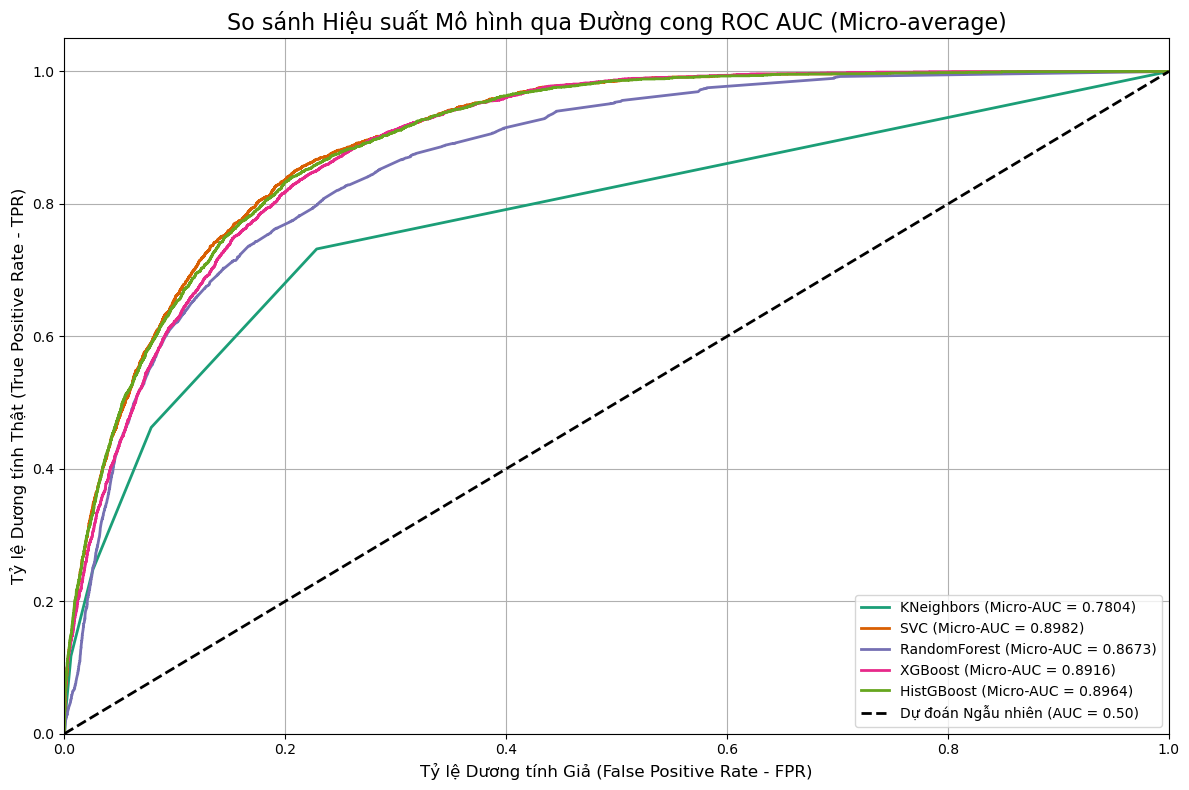

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Import 5 mô hình
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

# --- 1. KHỞI TẠO DANH SÁCH MÔ HÌNH VÀ HUẤN LUYỆN ---

# Lưu ý: SVC cần probability=True, các mô hình khác không cần.
models = [
    ("KNeighbors", KNeighborsClassifier(n_neighbors=5, n_jobs=-1)),
    ("SVC", SVC(probability=True, random_state=42)), 
    ("RandomForest", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)),
    ("XGBoost", XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')),
    ("HistGBoost", HistGradientBoostingClassifier(random_state=42)),
]

# Chuyển đổi nhãn về mảng numpy (đảm bảo y_val có thể sử dụng được)
if isinstance(y_val, (pd.Series, pd.DataFrame)):
    y_val_array = y_val.values.flatten()
else:
    y_val_array = y_val

# Binarize nhãn thật (One-hot encoding)
classes = np.unique(y_val_array)
y_val_bin = label_binarize(y_val_array, classes=classes)

# --- 2. TÍNH TOÁN VÀ VẼ BIỂU ĐỒ ---
plt.figure(figsize=(12, 8))
lw = 2
colors = cycle(plt.cm.get_cmap('Dark2').colors)

print("Bắt đầu tính toán và vẽ đường cong ROC Micro-average cho 5 mô hình...")

for name, model in models:
    print(f"-> Đang huấn luyện và tính AUC cho: {name}...")
    
    # Huấn luyện mô hình
    model.fit(X_train, y_train)
    
    # Dự đoán xác suất
    y_score = model.predict_proba(X_val)
    
    # Tính toán Micro-average ROC AUC
    # Để tính Micro-average, ta làm phẳng (flatten) tất cả các nhãn và xác suất
    fpr_micro, tpr_micro, _ = roc_curve(y_val_bin.ravel(), y_score.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    
    # Vẽ đường cong cho mô hình hiện tại
    color = next(colors)
    plt.plot(fpr_micro, tpr_micro, color=color, lw=lw,
             label=f'{name} (Micro-AUC = {roc_auc_micro:0.4f})')

print("Hoàn tất.")

# Vẽ đường chéo ngẫu nhiên (y=x)
plt.plot([0, 1], [0, 1], 'k--', lw=lw, label='Dự đoán Ngẫu nhiên (AUC = 0.50)')

# Đặt nhãn và tiêu đề
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tỷ lệ Dương tính Giả (False Positive Rate - FPR)', fontsize=12)
plt.ylabel('Tỷ lệ Dương tính Thật (True Positive Rate - TPR)', fontsize=12)
plt.title('So sánh Hiệu suất Mô hình qua Đường cong ROC AUC (Micro-average)', fontsize=16)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig('../doc/fig/roc_auc.png') 
plt.show()